In [1]:
# Python imports
import json
import os
import shutil
import warnings

# Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Locals
import oggm
from oggm import cfg, utils, tasks, workflow
from oggm.workflow import execute_entity_task, init_glacier_directories
from oggm.core.massbalance import (ConstantMassBalance, PastMassBalance,
                                   MultipleFlowlineMassBalance)

In [2]:
# Module logger
import logging
log = logging.getLogger(__name__)

In [3]:
# Papermill parameters
rgi_version = '62'
baseline_climate = 'CERA+ERA5'
fl_type = 'elev_bands'
climate_qc_months = 3
border = 10
prcp_scaling_factor = 1.6

In [4]:
# Parameters
baseline_climate = "CRU"
fl_type = "centerlines"
climate_qc_months = 3
prcp_scaling_factor = 2.5


In [5]:
rgi_version = str(rgi_version)
climate_qc_months = int(climate_qc_months)
border = int(border)
prcp_scaling_factor = float(prcp_scaling_factor)

In [6]:
print(f'''# User params:
rgi_version = {rgi_version}
baseline_climate = {baseline_climate}
fl_type = {fl_type}
climate_qc_months = {climate_qc_months}
border = {border}
prcp_scaling_factor = {prcp_scaling_factor}
''')

# User params:
rgi_version = 62
baseline_climate = CRU
fl_type = centerlines
climate_qc_months = 3
border = 10
prcp_scaling_factor = 2.5



In [7]:
run_dir = utils.gettempdir('mb_calib', home=True)
dirname =  os.path.join(f'RGIV{rgi_version}', f'{baseline_climate}', f'{fl_type}', f'qc{climate_qc_months}', f'pcp{prcp_scaling_factor:.1f}')
WORKING_DIR = os.path.join(run_dir, dirname)
print(f'Working dir: {WORKING_DIR}')

Working dir: /home/users/fmaussion/tmp/OGGM/mb_calib/RGIV62/CRU/centerlines/qc3/pcp2.5


In [8]:
# Start from zero?
reset = True

# Initialize OGGM and set up the run parameters
cfg.initialize(logging_level='WARNING')

# Local paths (where to write the OGGM run output)
utils.mkdir(WORKING_DIR, reset=reset);
utils.mkdir(os.path.join(WORKING_DIR, 'log'), reset=True);

SCORES_DIR = os.path.join(WORKING_DIR, '_scores')
utils.mkdir(SCORES_DIR);

2021-01-29 22:46:51: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.


2021-01-29 22:46:51: oggm.cfg: Multiprocessing switched ON according to the parameter file.


2021-01-29 22:46:51: oggm.cfg: Multiprocessing: using all available processors (N=32)


In [9]:
cfg.PATHS['working_dir'] = WORKING_DIR
cfg.PARAMS['run_mb_calibration'] = True
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = False
cfg.PARAMS['border'] = border
cfg.PARAMS['climate_qc_months'] = climate_qc_months
cfg.PARAMS['dl_verify'] = False
cfg.PARAMS['baseline_climate'] = baseline_climate
cfg.PARAMS['prcp_scaling_factor'] = prcp_scaling_factor

2021-01-29 22:46:51: oggm.cfg: PARAMS['run_mb_calibration'] changed from `False` to `True`.


2021-01-29 22:46:51: oggm.cfg: PARAMS['border'] changed from `20` to `10`.


2021-01-29 22:46:51: oggm.cfg: PARAMS['dl_verify'] changed from `True` to `False`.


In [10]:
# Prepare the preprocessed dirs
df, _ = utils.get_wgms_files()
rids = df['RGI{}0_ID'.format(rgi_version[0])]
print('Number of potential ref glaciers: {}'.format(len(rids)))

Number of potential ref glaciers: 279


In [11]:
base_url = f'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/{fl_type}/'

print('base url: {}'.format(base_url))

base url: https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/centerlines/


In [12]:
all_gdirs = init_glacier_directories(rids, from_prepro_level=2, prepro_base_url=base_url, prepro_rgi_version=rgi_version)

2021-01-29 22:46:51: oggm.workflow: init_glacier_directories from prepro level 2 on 279 glaciers.


2021-01-29 22:46:51: oggm.workflow: Execute entity task gdir_from_prepro on 279 glaciers


In [13]:
ref_list_f = os.path.join(SCORES_DIR, 'available_ref_glaciers.csv')
if not os.path.exists(ref_list_f):
    
    # Get the reference glacier ids
    df, _ = utils.get_wgms_files()
    rids = df['RGI{}0_ID'.format(rgi_version[0])]

    if 'CRU' in baseline_climate:
        # For CRU we can't do Antarctica
        gdirs = [gdir for gdir in all_gdirs if gdir.rgi_region != '19']
    else:
        # take all
        gdirs = [gdir for gdir in all_gdirs]

    # We need to know which period we have data for
    log.workflow('Process the climate data...')
    execute_entity_task(tasks.process_climate_data, gdirs,
                        print_log=False)
    if climate_qc_months > 0:
        execute_entity_task(tasks.historical_climate_qc, gdirs,
                            print_log=False)

    # Let OGGM decide which of these have enough data
    gdirs = utils.get_ref_mb_glaciers(gdirs)
    
    # Manual removal of bad actors
    if 'CRU' in baseline_climate:
        bad = ['RGI60-15.06557', 'RGI60-15.06777']
        gdirs = [gd for gd in gdirs if gd.rgi_id not in bad]

    # Save the list of glaciers for later
    log.workflow('N reference glaciers after climate check: {}'.format(len(gdirs)))
    rgidf = pd.Series(data=[g.rgi_id for g in gdirs])
    rgidf.to_csv(ref_list_f, header=False)
else:
    # Read the rgi ids of the reference glaciers
    rids = pd.read_csv(ref_list_f, index_col=0, squeeze=True).values
    gdirs = [gdir for gdir in all_gdirs if gdir.rgi_id in rids]

2021-01-29 22:46:54: __main__: Process the climate data...


2021-01-29 22:46:54: oggm.workflow: Execute entity task process_climate_data on 274 glaciers


2021-01-29 22:47:19: oggm.workflow: Execute entity task historical_climate_qc on 274 glaciers


2021-01-29 22:47:23: __main__: N reference glaciers after climate check: 266


In [14]:
# Climate tasks
tasks.compute_ref_t_stars(gdirs)
execute_entity_task(tasks.local_t_star, gdirs)
execute_entity_task(tasks.mu_star_calibration, gdirs)

# We store the associated params
mb_calib = gdirs[0].get_climate_info()['mb_calib_params']
params_file = os.path.join(WORKING_DIR, 'ref_tstars_params.json')
with open(params_file, 'w') as fp:
    json.dump(mb_calib, fp)

# And also some statistics
diag_path = os.path.join(SCORES_DIR, 'glacier_statistics.csv')
utils.compile_glacier_statistics(gdirs, path=diag_path)
diag_path = os.path.join(SCORES_DIR, 'fixed_geometry_mass_balance.csv')
utils.compile_fixed_geometry_mass_balance(gdirs, path=diag_path)

# Tests: for all glaciers, the mass-balance around tstar and the
# bias with observation should be approx 0
log.workflow('Starting validation loop...')
for gd in gdirs:
    mbmod = MultipleFlowlineMassBalance(gd,
                                        mb_model_class=ConstantMassBalance,
                                        use_inversion_flowlines=True,
                                        bias=0)  # bias=0 because of calib!
        
    mb = mbmod.get_specific_mb()
    np.testing.assert_allclose(mb, 0, atol=10)  # atol for numerical errors

    mbmod = MultipleFlowlineMassBalance(gd, mb_model_class=PastMassBalance,
                                        use_inversion_flowlines=True)

    refmb = gd.get_ref_mb_data().copy()
    refmb['OGGM'] = mbmod.get_specific_mb(year=refmb.index)
    np.testing.assert_allclose(refmb.OGGM.mean(),
                               refmb.ANNUAL_BALANCE.mean(),
                               atol=15)  # atol for numerical errors

# Log
log.workflow('Calibration is done!')

2021-01-29 22:47:24: oggm.workflow: Execute entity task t_star_from_refmb on 266 glaciers


2021-01-29 22:47:25: oggm.workflow: Execute entity task local_t_star on 266 glaciers


2021-01-29 22:47:26: oggm.workflow: Execute entity task mu_star_calibration on 266 glaciers


2021-01-29 22:47:27: oggm.workflow: Execute entity task glacier_statistics on 266 glaciers


2021-01-29 22:47:28: oggm.workflow: Execute entity task fixed_geometry_mass_balance on 266 glaciers


2021-01-29 22:47:30: __main__: Starting validation loop...


2021-01-29 22:47:57: __main__: Calibration is done!


## Cross-val 

2021-01-29 22:47:57: __main__: Cross-validation loop...


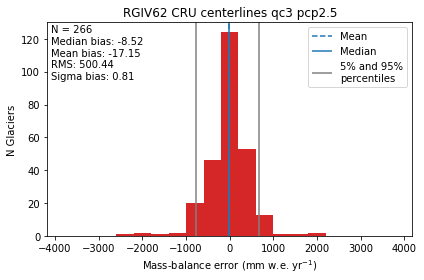

N = 266
Median bias: -8.52
Mean bias: -17.15
RMS: 500.44
Sigma bias: 0.81



In [15]:
# Cross-validation
ref_df = pd.read_csv(os.path.join(WORKING_DIR, 'ref_tstars.csv'), index_col=0)
log.workflow('Cross-validation loop...')
for i, gdir in enumerate(gdirs):
    # Now recalibrate the model blindly
    tmp_ref_df = ref_df.loc[ref_df.index != gdir.rgi_id]
    tasks.local_t_star(gdir, ref_df=tmp_ref_df)
    tasks.mu_star_calibration(gdir)

    # Mass-balance model with cross-validated parameters instead
    mb_mod = MultipleFlowlineMassBalance(gdir,
                                         mb_model_class=PastMassBalance,
                                         use_inversion_flowlines=True)

    # Mass-balance timeseries, observed and simulated
    refmb = gdir.get_ref_mb_data().copy()
    refmb['OGGM'] = mb_mod.get_specific_mb(year=refmb.index)

    # Compare their standard deviation
    std_ref = refmb.ANNUAL_BALANCE.std()
    
    with warnings.catch_warnings():
        # This can trigger a divide by zero Warning
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        rcor = np.corrcoef(refmb.OGGM, refmb.ANNUAL_BALANCE)[0, 1]
        if std_ref == 0:
            # such a thing happens with some geodetic values
            std_ref = refmb.OGGM.std()
            rcor = 1

        # Store the scores
        ref_df.loc[gdir.rgi_id, 'CV_MB_BIAS'] = (refmb.OGGM.mean() -
                                                 refmb.ANNUAL_BALANCE.mean())
        ref_df.loc[gdir.rgi_id, 'CV_MB_SIGMA_BIAS'] = refmb.OGGM.std() / std_ref
        ref_df.loc[gdir.rgi_id, 'CV_MB_COR'] = rcor

# Write out
ref_df.to_csv(os.path.join(SCORES_DIR, 'crossval_tstars.csv'))

scores = 'N = {}\n'.format(len(gdirs))
scores += 'Median bias: {:.2f}\n'.format(ref_df['CV_MB_BIAS'].median())
scores += 'Mean bias: {:.2f}\n'.format(ref_df['CV_MB_BIAS'].mean())
scores += 'RMS: {:.2f}\n'.format(np.sqrt(np.mean(ref_df['CV_MB_BIAS']**2)))
scores += 'Sigma bias: {:.2f}\n'.format(np.mean(ref_df['CV_MB_SIGMA_BIAS']))

# Marzeion et al Figure 3
f, ax = plt.subplots(1, 1)
bins = np.arange(20) * 400 - 3800
ylim = 130
ref_df['CV_MB_BIAS'].plot(ax=ax, kind='hist', bins=bins, color='C3',
                          label='')
ax.vlines(ref_df['CV_MB_BIAS'].mean(), 0, ylim, linestyles='--',
          label='Mean')
ax.vlines(ref_df['CV_MB_BIAS'].quantile(), 0, ylim, label='Median')
ax.vlines(ref_df['CV_MB_BIAS'].quantile([0.05, 0.95]), 0, ylim,
          color='grey', label='5% and 95%\npercentiles')
ax.text(0.01, 0.99, scores,
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

ax.set_ylim(0, ylim)
ax.set_ylabel('N Glaciers')
ax.set_xlabel('Mass-balance error (mm w.e. yr$^{-1}$)')
ax.legend(loc='best')
plt.title('{}'.format(dirname.replace('/', ' ')))
plt.tight_layout()
plt.savefig(os.path.join(SCORES_DIR, 'cv_histogram.png'),
            dpi=150, bbox_inches='tight')
plt.show()

# Output
print(scores)
fn = os.path.join(SCORES_DIR, 'scores.txt')
with open(fn, 'w') as f:
    f.write(scores)

## Ref Tstar analysis

(195.18988454494075, 51.75722665668961)

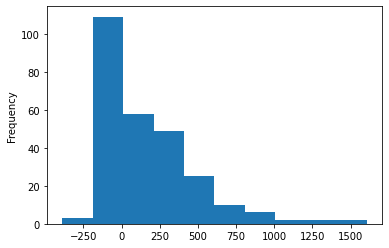

In [16]:
df = pd.read_csv(os.path.join(WORKING_DIR, 'ref_tstars.csv'), index_col=0)
df.bias.plot(kind='hist');
df.bias.mean(), df.bias.median()

## Delete data

In [17]:
shutil.rmtree(os.path.join(WORKING_DIR, 'log'))
shutil.rmtree(os.path.join(WORKING_DIR, 'per_glacier'))